# House Prices Prediction Model

This model takes a dataset of 17 features related to a building which are used to predict the prices of the House.
- Date: The date when the property was sold. This feature helps in understanding the temporal trends in property prices.
- Price:The sale price of the property in USD. This is the target variable we aim to predict.
- Bedrooms:The number of bedrooms in the property. Generally, properties with more bedrooms tend to have higher prices.
- Bathrooms: The number of bathrooms in the property. Similar to bedrooms, more bathrooms can increase a property’s value.
- Sqft Living: The size of the living area in square feet. Larger living areas are typically associated with higher property values.
- Sqft Lot:The size of the lot in square feet. Larger lots may increase a property’s desirability and value.
- Floors: The number of floors in the property. Properties with multiple floors may offer more living space and appeal.
- Waterfront: A binary indicator (1 if the property has a waterfront view, 0 other-wise). Properties with waterfront views are often valued higher.
- View: An index from 0 to 4 indicating the quality of the property’s view. Better views are likely to enhance a property’s value.
- Condition: An index from 1 to 5 rating the condition of the property. Properties in better condition are typically worth more.
- Sqft Above: The square footage of the property above the basement. This can help isolate the value contribution of above-ground space.
- Sqft Basement: The square footage of the basement. Basements may add value depending on their usability.
- Yr Built: The year the property was built. Older properties may have historical value, while newer ones may offer modern amenities.
- Yr Renovated: The year the property was last renovated. Recent renovations can increase a property’s appeal and value.
- Street: The street address of the property. This feature can be used to analyze location-specific price trends.
- City: The city where the property is located. Different cities have distinct market dynamics.
- Statezip: The state and zip code of the property. This feature provides regional context for the property.
- Country: The country where the property is located. While this dataset focuses on properties in Australia, this feature is included for completeness.

In [119]:
#Import and Install required libraries
!pip install catboost
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR




original_dataset = pd.read_csv('./USA Housing Dataset.csv')
original_dataset.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-09 00:00:00,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA
1,2014-05-09 00:00:00,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA
2,2014-05-09 00:00:00,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA
3,2014-05-09 00:00:00,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,820 NW 95th St,Seattle,WA 98117,USA
4,2014-05-10 00:00:00,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA


## Understanding the dataset

In [120]:
#Check for missing values
original_dataset.isna().sum()

,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0
condition,0


In [121]:
#No of entries in the dataset
len(original_dataset)

4140

In [122]:
#Structure of dataset
original_dataset.shape

(4140, 18)

## Cleaning the dataset

In [123]:
working_dataset = original_dataset.copy()

In [124]:
#Strip the whitespaces in the column name of the dataset
working_dataset.columns = working_dataset.columns.str.strip()

#Strip the extra whitespaces contained in each string/object entries in the dataset
for col in working_dataset.columns:
    if working_dataset[col].dtype == 'object':
        working_dataset[col] = working_dataset[col].str.strip()

In [125]:
#Convert the date column to datetime dtype and create a year and month column
working_dataset['date'] = pd.to_datetime(working_dataset['date'], infer_datetime_format=True)
working_dataset['year'] = working_dataset['date'].dt.year
working_dataset['month'] = working_dataset['date'].dt.month

<ipython-input-125-a727d1119912>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  working_dataset['date'] = pd.to_datetime(working_dataset['date'], infer_datetime_format=True)


In [126]:
#Creating a variable that holds columns containing only numerical values
numbers = working_dataset.drop(['date', 'country', 'city', 'street', 'statezip', 'year'], axis=1)
numbers.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,month
0,376000.0,3.0,2.00,1340,1384,3.0,0,0,3,1340,0,2008,0,5
1,800000.0,4.0,3.25,3540,159430,2.0,0,0,3,3540,0,2007,0,5
2,2238888.0,5.0,6.50,7270,130017,2.0,0,0,3,6420,850,2010,0,5
3,324000.0,3.0,2.25,998,904,2.0,0,0,3,798,200,2007,0,5
4,549900.0,5.0,2.75,3060,7015,1.0,0,0,5,1600,1460,1979,0,5


In [127]:
cleaned_dataset = working_dataset.copy()

## Visualization of dataset

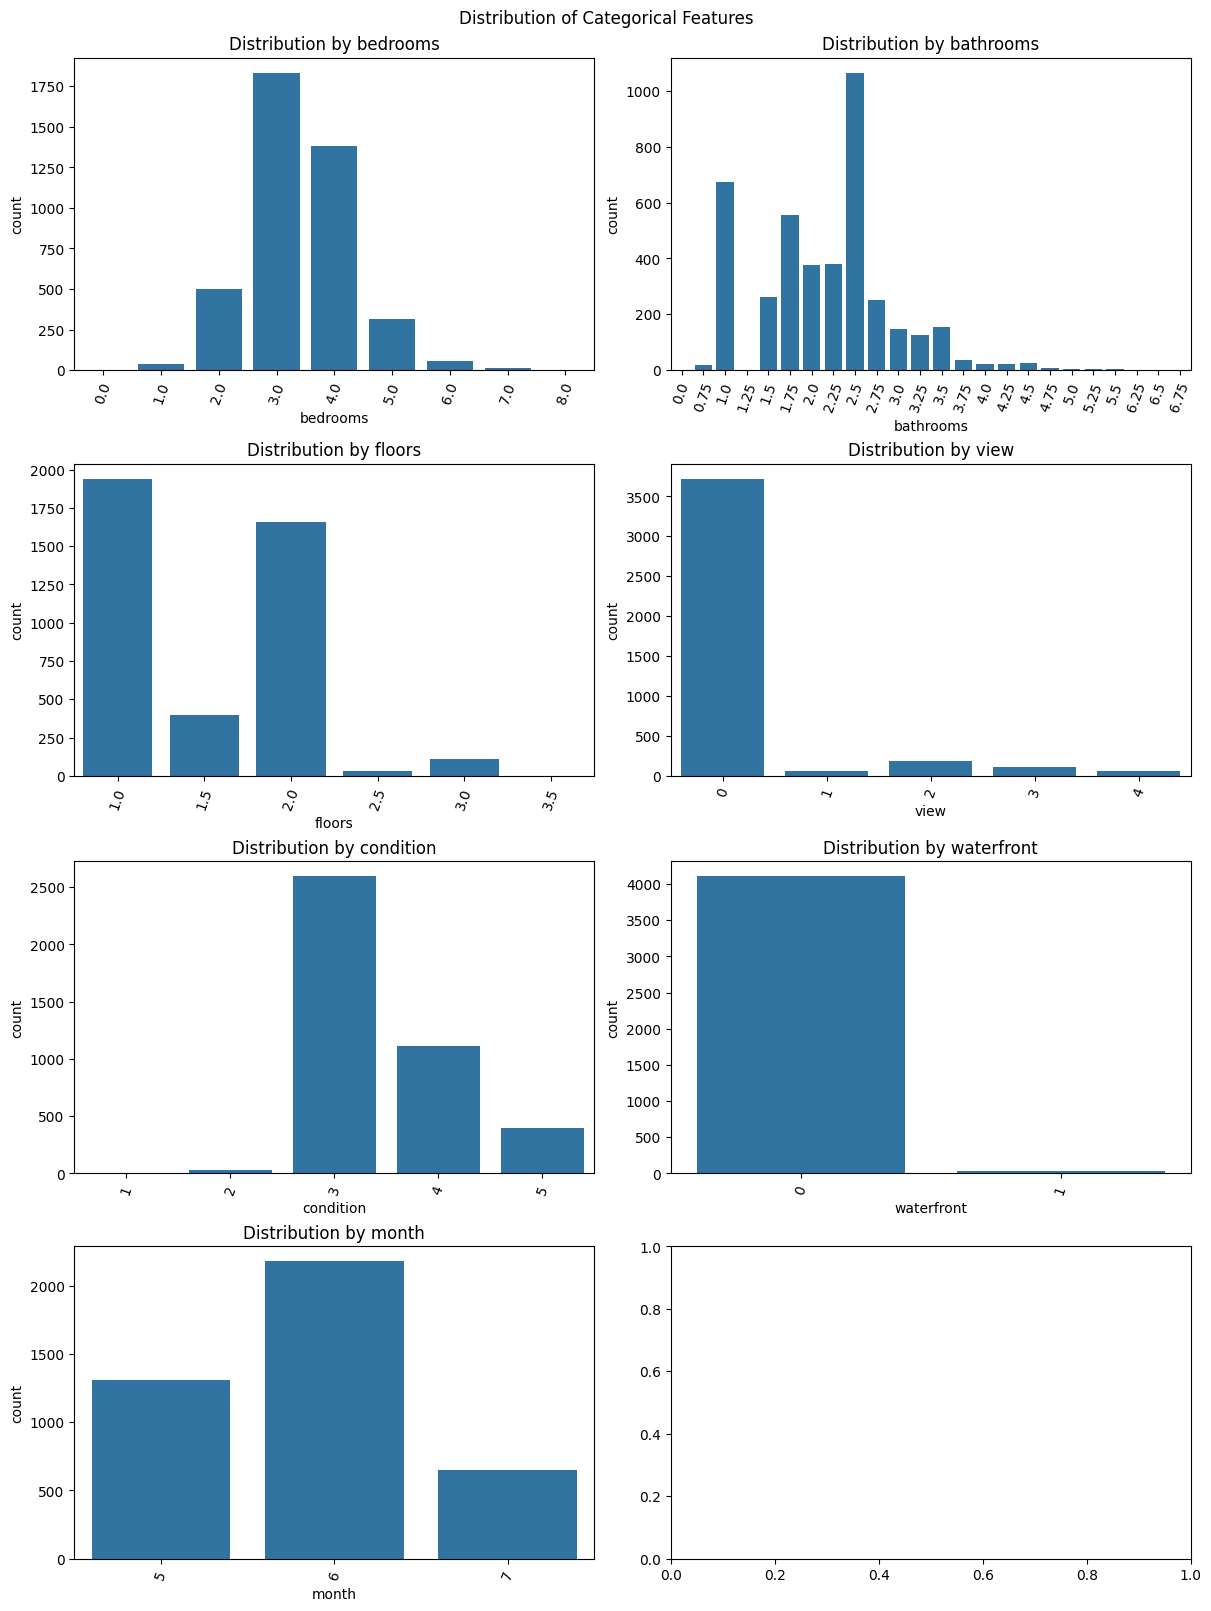

In [128]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), constrained_layout = True)
fig.suptitle('Distribution of Categorical Features')

cat_columns = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'waterfront', 'month']

for ax, cat in zip(axes.flatten(), cat_columns):
    sns.countplot(data=working_dataset, x=cat, ax=ax)
    ax.set_title(f'Distribution by {cat}')
    ax.tick_params(axis='x', labelrotation = 70)



plt.show()

1. **Distribution by Bedrooms**
    Most properties have 3 or 4 bedrooms, with 3 being the most common.
    There are a few outliers with high bedroom counts, such as 7 and 8, but these are rare.
    Indicates that properties with 3 bedrooms dominate this dataset.
    
2. **Distribution by Bathrooms**
    The distribution of bathrooms shows that most properties have between 1 and 3 bathrooms.
    The most common counts are 1.0, 1.5, 2.0, and 2.5 bathrooms.
    There are a few properties with a high number of bathrooms (up to 6.75), but these are relatively rare, suggesting they may be large, high-end properties.
    
3. **Distribution by Floors**
    Properties with 1.0 and 2.0 floors are the most common, with 1.0 being slightly more frequent.
    There are very few properties with more than 2 floors, making them rare cases in this dataset.
    
4. **Distribution by View**
    The majority of properties have a view score of 0, which likely means they have no special view.
    Very few properties have higher view scores (1 to 4), suggesting that only a small percentage of properties have notable views.
    
5. **Distribution by Condition**
    The condition ratings show that most properties are rated 3 or 4, with 3 being the most common.
    Very few properties have a condition rating of 1 or 2, suggesting that poorly maintained properties are rare in this dataset.
    
6. **Distribution by Waterfront**
    This feature is highly imbalanced, with almost all properties having a waterfront score of 0 (no waterfront).
    Only a few properties have a waterfront score of 1, indicating they are located on or near a waterfront, making waterfront properties rare.
    
7. **Distribution by Month**
    This plot shows the count of properties by month, likely representing the month of sale.
    June has the highest count, followed by May, while July has the lowest among these three months.
    This could suggest a seasonal trend, with more properties sold in May and June.
    
***Overall Summary***
    
    These distributions reveal a few patterns:
    
        Common Property Features: Most properties have 3 bedrooms, 1-2 bathrooms, 1-2 floors, a condition rating of 3-4, no notable view, and no waterfront access.
    
        Rare High-End Features: Properties with a high number of bedrooms, bathrooms, or special features like waterfront access and high view ratings are much less common.
    
        Seasonal Sales Pattern: Sales peak in June and decrease in July, suggesting some seasonality in the real estate market.

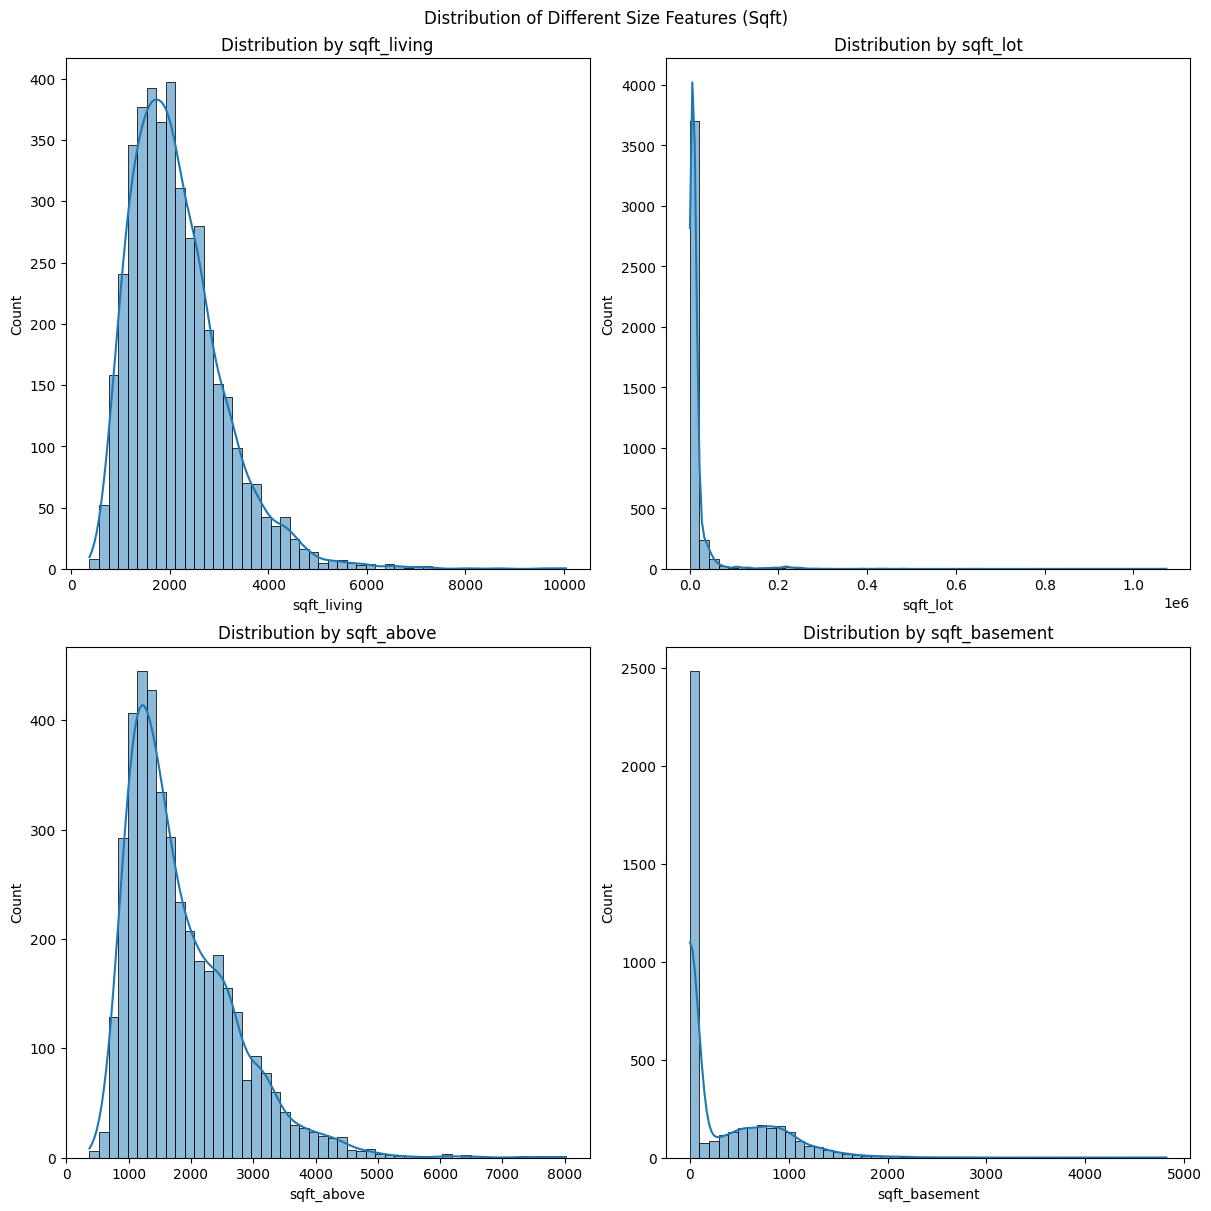

In [129]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), constrained_layout = True)
fig.suptitle('Distribution of Different Size Features (Sqft)')

sqft_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for ax, size in zip(axes.flatten(), sqft_columns):
    sns.histplot(data=working_dataset, x=size, ax=ax, bins=50, kde=True)
    ax.set_title(f'Distribution by {size}')



plt.show()

- **Distribution of sqft_living**:
    The distribution is right-skewed, with most properties having a living area under 3000 sqft. Only a few properties have much larger living areas, as indicated by the tail extending towards 10,000 sqft.

- **Distribution of sqft_lot**:
    The distribution is also highly right-skewed, with the vast majority of properties having small lot sizes. A few properties have extremely large lot sizes (reaching up to 1 million sqft), contributing to the long tail on the right.

- **Distribution of sqft_above**:
    Similar to sqft_living, this distribution is right-skewed, with most properties under 3000 sqft. A small number of properties with larger sqft_above values result in a tail extending towards 8,000 sqft.

- **Distribution of sqft_basement**:
    The distribution is heavily right-skewed, with most properties having no basement (i.e basement size of 0) or very small basements. However, some properties have larger basements, resulting in a tail that extends to around 5,000 sqft.

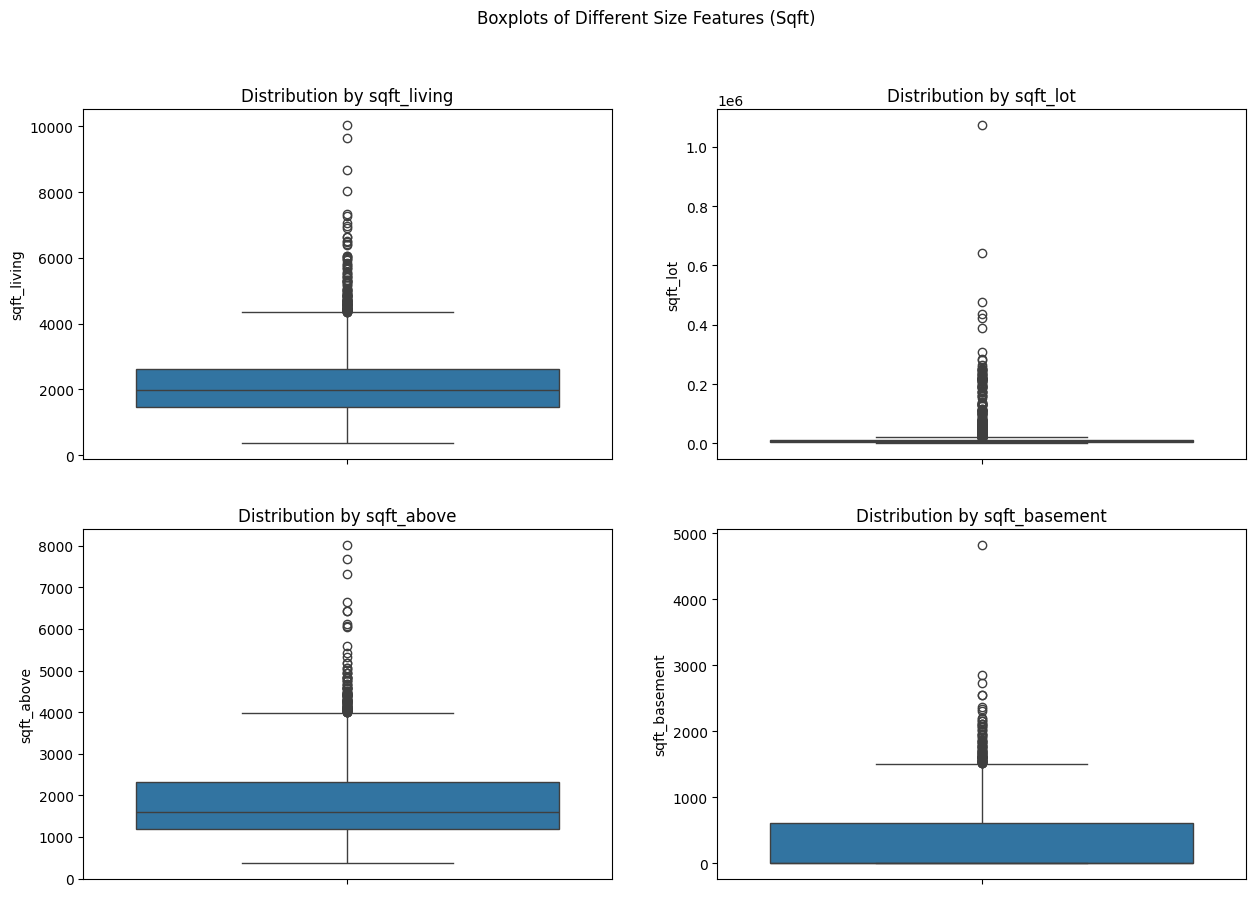

In [130]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Boxplots of Different Size Features (Sqft)')


for ax, size in zip(axes.flatten(), sqft_columns):
    sns.boxplot(data=working_dataset, y=size, ax=ax)
    ax.set_title(f'Distribution by {size}')



plt.show()


The boxplot shows the presence of outliers more intuitively
- **Distribution of sqft_living**:
    The boxplot indicates that most values of sqft_living are concentrated between 1,000 and 3,000 sqft. There are a significant number of outliers above the upper whisker (around 4,000 sqft), extending up to 10,000 sqft.
    
- **Distribution of sqft_lot**:
    This feature has extreme outliers, as seen by the large number of points far above the upper whisker. Most lot sizes are close to the lower end of the scale, but some reach up to 1 million sqft, indicating a few exceptionally large properties.
    
- **Distribution of sqft_above**:
    Similar to sqft_living, this feature shows most values between 1,000 and 3,000 sqft, with a few outliers extending upwards. The outliers reach up to around 7,000 sqft, showing that a small portion of properties have very large above-ground areas.
    
- **Distribution of sqft_basement**:
    The majority of basement sizes are clustered below 1,000 sqft, with a few extreme outliers. The largest basement size reaches around 4,000 sqft, indicating that a few properties have very large basements.
    

The skewness observed in the distributions (with long tails to the right) is reflected in these boxplots.

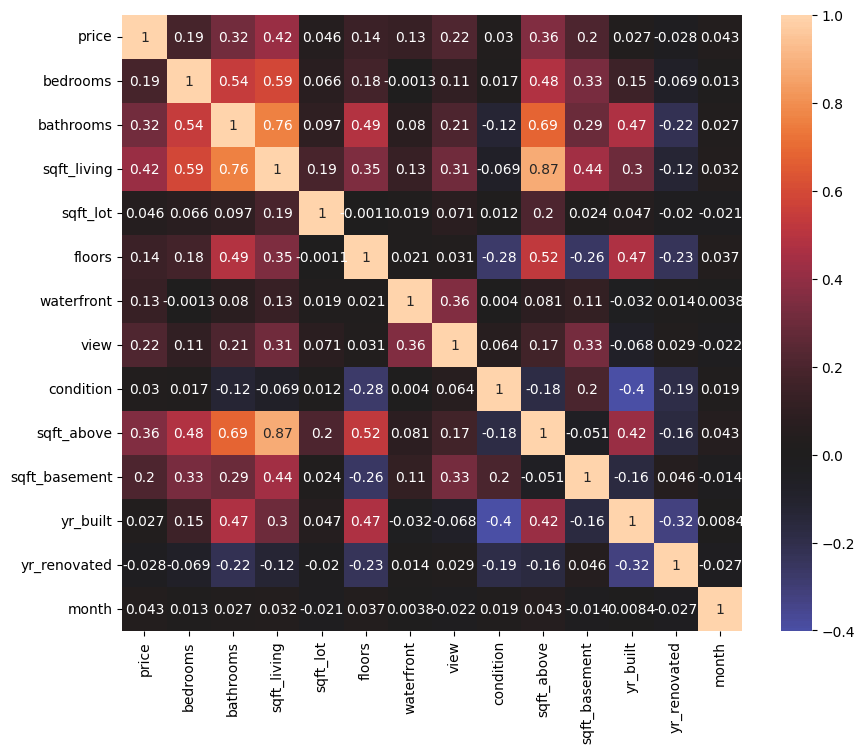

In [131]:
fig,ax=plt.subplots(figsize=(10,8))
sns.heatmap(numbers.corr(), annot=True, center=0)
plt.show()

1. **Correlation with Price**

    - **sqft_living (0.42)**: Has a moderately strong positive correlation with price, meaning that as living space increases, the price also tends to increase.
    - **bathrooms (0.32) and sqft_above (0.36)**: These features also show moderate positive correlations with price, suggesting that more bathrooms and larger above-ground space are associated with higher prices.
    - **view (0.22) and waterfront (0.13)**: Both show a positive correlation with price, indicating that properties with views or waterfronts tend to be priced higher, although the correlation is weaker.
    - **floors (0.14) and bedrooms (0.19)**: These show weaker correlations, suggesting that they don’t have as strong an influence on price compared to features like square footage.
    
2. **High Correlations Between Features**

    - **sqft_living and sqft_above (0.87)**: These two are highly correlated, which is logical since above-ground square footage contributes significantly to total living space.
    - **bathrooms and sqft_living (0.76)**: Indicates that larger homes tend to have more bathrooms.
    - **bedrooms and bathrooms (0.54)**: This indicates that homes with more bedrooms are likely to have more bathrooms.
    - **floors and sqft_above (0.52)**: Indicates that homes with more floors tend to have more above-ground square footage.
    
3. **Negative Correlations**
    - **yr_built and condition (-0.40)**: Indicates that older homes tend to have lower condition ratings, which may reflect wear and tear over time.
    - **yr_built and bathrooms (-0.47) and yr_built and sqft_above (-0.42)**: Suggests that newer homes tend to have more bathrooms and more above-ground square footage.
    - **sqft_basement and condition (-0.26)**: Suggests that homes with larger basements might have slightly poorer condition ratings, though this is a relatively weak relationship.
    
4. **Observations of Weak or Low Correlations**
     Features like sqft_lot, month, and yr_renovated show very weak correlations with most other variables, indicating that they may have limited influence on the other features in this dataset.
    month has almost no correlation with price, suggesting that the month in which a property was listed or sold does not strongly influence its price.
    
**Overall Summary**
- Price is most strongly correlated with living space features like sqft_living and sqft_above, as well as the number of bathrooms and views.

- **Multi-Collinearity**: Some features, such as sqft_living and sqft_above, are highly correlated with each other, indicating redundancy. This could be addressed during feature selection or modeling.

- **Age and Condition**: Older homes tend to be in poorer condition and have smaller above-ground square footage.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


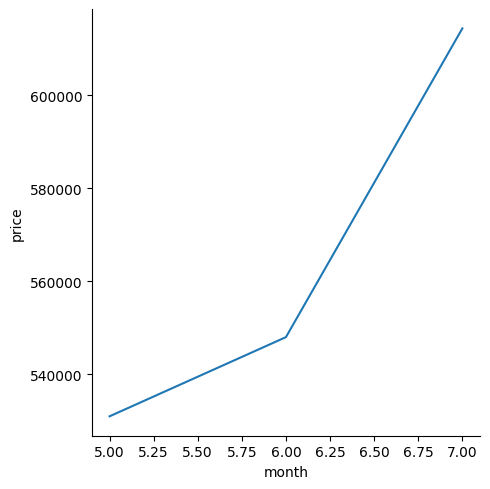

In [132]:
sns.relplot(data=working_dataset, x='month', y='price', kind='line', markers=True, ci=None)
plt.show()

There is a noticeable upward trend in price from month 5 to month 7. This suggests that prices tend to increase over these months.

In [133]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap the outliers
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

# Apply the function to each asset column
for col in sqft_columns:
    df = cap_outliers(working_dataset, col)

# Check the resulting values
print(df[sqft_columns].describe())

       sqft_living      sqft_lot   sqft_above  sqft_basement
count  4140.000000   4140.000000  4140.000000    4140.000000
mean   2119.095894   8919.103623  1815.431401     305.304952
std     869.785608   5376.994415   805.113573     438.871844
min     370.000000    638.000000   370.000000       0.000000
25%    1470.000000   5000.000000  1190.000000       0.000000
50%    1980.000000   7676.000000  1600.000000       0.000000
75%    2620.000000  11000.000000  2310.000000     602.500000
max    4345.000000  20000.000000  3990.000000    1506.250000


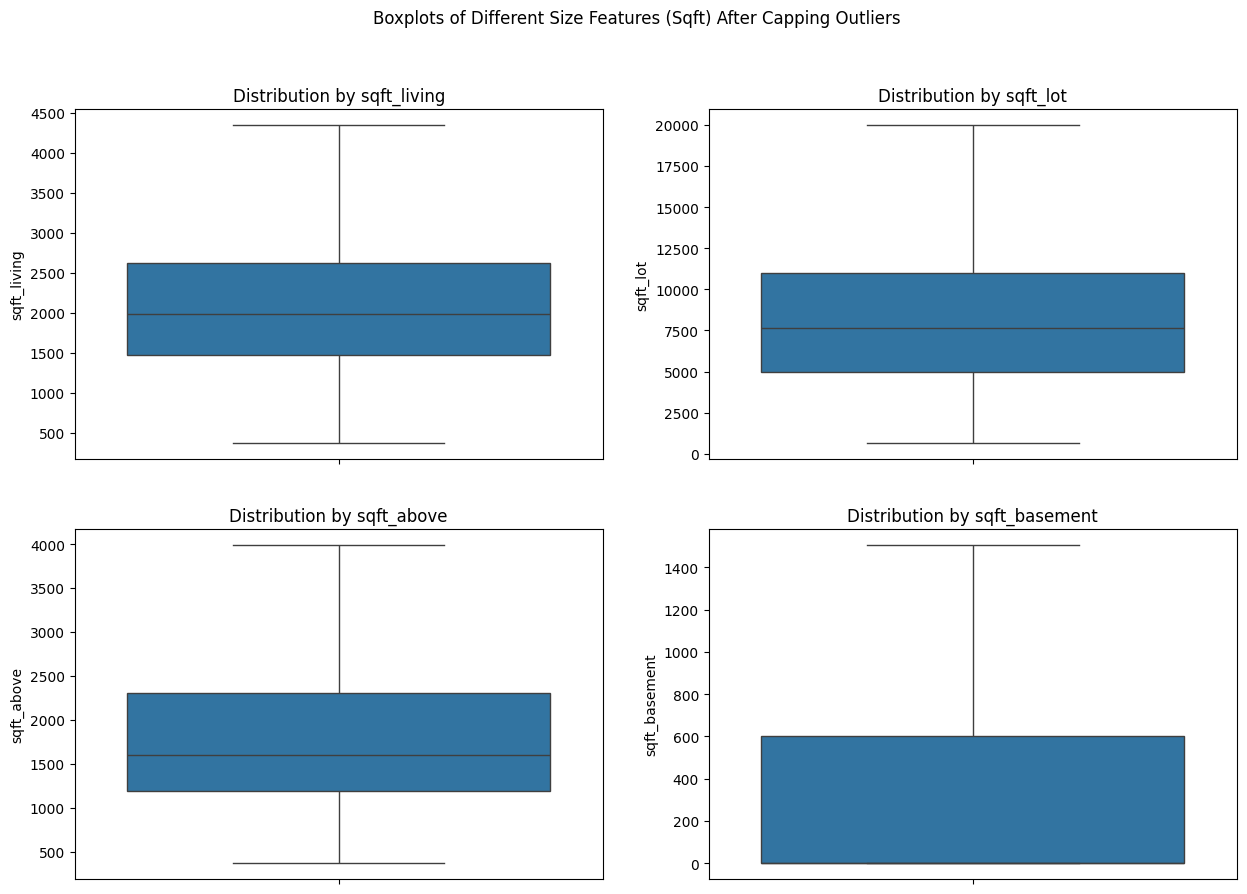

In [134]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Boxplots of Different Size Features (Sqft) After Capping Outliers')


for ax, size in zip(axes.flatten(), sqft_columns):
    sns.boxplot(data=working_dataset, y=size, ax=ax)
    ax.set_title(f'Distribution by {size}')



plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


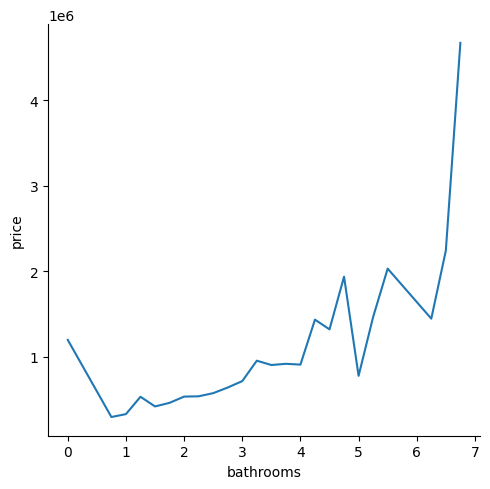

In [135]:
sns.relplot(data=working_dataset, x='bathrooms', y='price', kind='line', markers=True, ci=None)
plt.show()

The trend suggests that the number of bathrooms is positively correlated with property price. However there are fluctuations which imply that the relationship is not perfectly straightforward; other factors are likely at play in determining property price.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


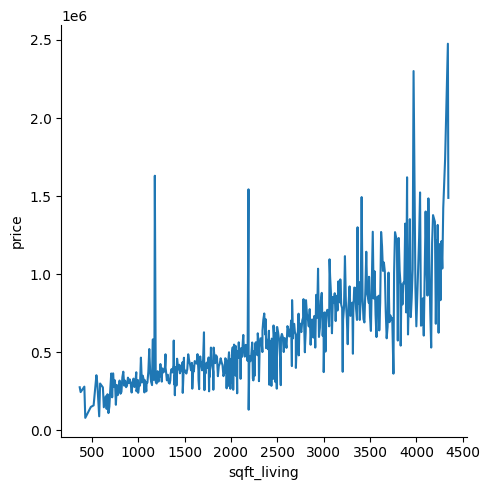

In [136]:
sns.relplot(data=working_dataset, x='sqft_living', y='price', kind='line', markers=True, ci=None)
plt.show()

The overall trend suggests that square footage of living space is a strong predictor of property price. There are notable spikes and variability in price at certain square footage values. This indicates that other factors are likely influencing the price in addition to square footage. The sharp increases in price at the upper range (above 4000sqft), likely represents luxury homes or estates with premium features and locations.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


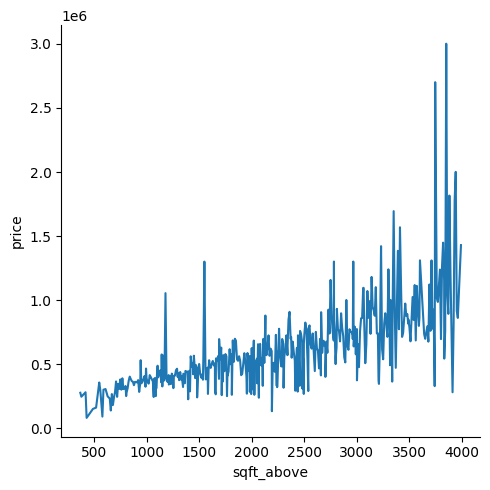

In [137]:
sns.relplot(data=working_dataset, x='sqft_above', y='price', kind='line', markers=True, ci=None)
plt.show()

- **Strong Predictor**: sqft_above appears to be a strong predictor of property price, as larger above-ground spaces are highly valued.
- **Role of Outliers**: The sharp spikes in price (outliers) for large properties suggest the presence of luxury or estate homes.
- **Influence of Other Factors**: The fluctuations in price for properties with similar square footage imply that additional features (e.g., waterfront, view, or number of bathrooms) play a significant role in determining property value.


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 1000x1000 with 0 Axes>

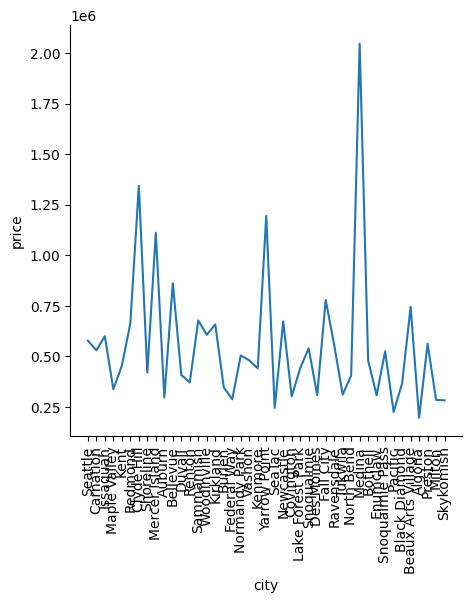

In [138]:
plt.figure(figsize=(10, 10))
sns.relplot(data=original_dataset, x='city', y='price', kind='line', markers=True, ci=None)
plt.xticks(rotation=90)
plt.show()

In [139]:
working_dataset.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,year,month
0,2014-05-09,376000.0,3.0,2.00,1340.0,1384.0,3.0,0,0,3,1340.0,0.0,2008,0,9245-9249 Fremont Ave N,Seattle,WA 98103,USA,2014,5
1,2014-05-09,800000.0,4.0,3.25,3540.0,20000.0,2.0,0,0,3,3540.0,0.0,2007,0,33001 NE 24th St,Carnation,WA 98014,USA,2014,5
2,2014-05-09,2238888.0,5.0,6.50,4345.0,20000.0,2.0,0,0,3,3990.0,850.0,2010,0,7070 270th Pl SE,Issaquah,WA 98029,USA,2014,5
3,2014-05-09,324000.0,3.0,2.25,998.0,904.0,2.0,0,0,3,798.0,200.0,2007,0,820 NW 95th St,Seattle,WA 98117,USA,2014,5
4,2014-05-10,549900.0,5.0,2.75,3060.0,7015.0,1.0,0,0,5,1600.0,1460.0,1979,0,10834 31st Ave SW,Seattle,WA 98146,USA,2014,5


## Preparing dataset for modeling

In [140]:
working_dataset = pd.get_dummies(working_dataset, columns=['city'], drop_first=True)

working_dataset.columns = working_dataset.columns.str.replace(' ', '_', regex=True)

In [141]:
#Split the features and target variable into X and Y
X = working_dataset.drop(['date', 'price', 'street', 'country', 'statezip'], axis=1)
Y = working_dataset['price']

In [142]:
#Log tranformation of column with skewed distribution
X['sqft_lot'] = np.log(X['sqft_lot'] + 1)
X['sqft_basement'] = np.log(X['sqft_basement'] + 1)

In [143]:
#Standardizing the sqft_living and sqft_above column
scaler = StandardScaler()
X['sqft_living'] = scaler.fit_transform(X[['sqft_living']])
X['sqft_above'] = scaler.fit_transform(X[['sqft_above']])


## Modeling the data

In [144]:
#Created a function that evaluates the model
def evaluate_model(model, X, Y, model_name):
    y_pred = model.predict(X)
    mae = mean_absolute_error(Y, y_pred)
    r2 = r2_score(Y, y_pred)

    results = {
        'Model': model_name,
        'MAE': mae,
        'R-squared': r2
    }
    results_df = pd.DataFrame([results])
    return results_df

In [145]:

all_metrics_df = pd.DataFrame()

models = [
    ('lasso', Lasso(alpha=1.0, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('elnet', ElasticNet(random_state=42, alpha=1.0)),
    ('dtr', DecisionTreeRegressor(random_state=42)),
    ('rfr', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=100, random_state=42)),
    ('cat', CatBoostRegressor(n_estimators=100, random_state=42, verbose=0)),
    ('mlp', MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', max_iter=500)),
    ('svr', SVR())
]



#Split X and Y into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


#Fitting the model and evaluating the model with the evaluate_model function
for name, model in models:
    model.fit(X_train, Y_train)
    metrics_df = evaluate_model(model, X_test, Y_test, name)
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

all_metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.557e+14, tolerance: 1.323e+11
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1170
[LightGBM] [Info] Number of data points in the train set: 3312, number of used features: 41
[LightGBM] [Info] Start training from score 556737.933249


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


,Model,MAE,R-squared
0,lasso,139718.825651,0.467395
1,ridge,139014.188848,0.480514
2,elnet,160611.590026,0.435284
3,dtr,169239.522193,-0.100817
4,rfr,130937.330306,0.455970
5,gbr,140210.871723,0.428785
6,xgb,131917.383047,0.445956
7,lgbm,153767.715331,0.242492
8,cat,148126.392531,0.271991
9,mlp,222662.264570,0.081266


In [146]:
all_metrics_df.sort_values(by='MAE',)

,Model,MAE,R-squared
4,rfr,130937.330306,0.455970
6,xgb,131917.383047,0.445956
1,ridge,139014.188848,0.480514
0,lasso,139718.825651,0.467395
5,gbr,140210.871723,0.428785
8,cat,148126.392531,0.271991
7,lgbm,153767.715331,0.242492
2,elnet,160611.590026,0.435284
3,dtr,169239.522193,-0.100817
10,svr,220812.471993,-0.065730


In [147]:
rfr= RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, Y_train)
rfr.score(X_test, Y_test)

0.4559702617071093

In [148]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(estimator=rfr, param_distributions=param_grid, cv=5, scoring='r2', n_iter=10, verbose=4)
random_search.fit(X_train, Y_train)

# Display the best parameters and score
print("Best parameters:", random_search.best_params_)
print("Best cross-validated score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=20, min_samples_split=10, n_estimators=100;, score=0.424 total time=   1.5s
[CV 2/5] END max_depth=20, min_samples_split=10, n_estimators=100;, score=0.062 total time=   1.4s
[CV 3/5] END max_depth=20, min_samples_split=10, n_estimators=100;, score=0.487 total time=   1.5s
[CV 4/5] END max_depth=20, min_samples_split=10, n_estimators=100;, score=0.330 total time=   1.4s
[CV 5/5] END max_depth=20, min_samples_split=10, n_estimators=100;, score=0.042 total time=   1.4s
[CV 1/5] END max_depth=None, min_samples_split=5, n_estimators=300;, score=0.451 total time=   6.2s
[CV 2/5] END max_depth=None, min_samples_split=5, n_estimators=300;, score=-0.166 total time=   5.2s
[CV 3/5] END max_depth=None, min_samples_split=5, n_estimators=300;, score=0.537 total time=   6.1s
[CV 4/5] END max_depth=None, min_samples_split=5, n_estimators=300;, score=0.241 total time=   5.2s
[CV 5/5] END max_depth=None, min_samples_sp

In [149]:
random_search.score(X_test, Y_test)

0.4729846347042549

In [153]:
importance_df = pd.Series(rfr.feature_importances_, index=X.columns).sort_values(ascending=True)

print(importance_df)

year                       0.000000e+00
city_Milton                4.184460e-07
city_Skykomish             1.237095e-06
city_Snoqualmie_Pass       2.820293e-06
city_Ravensdale            6.089794e-06
city_Preston               7.548507e-06
city_Carnation             2.281082e-05
city_Pacific               2.967350e-05
city_Duvall                5.757003e-05
city_Des_Moines            9.072662e-05
city_North_Bend            1.226301e-04
city_Fall_City             1.438145e-04
city_Vashon                1.459819e-04
city_Bothell               1.551601e-04
city_SeaTac                1.740653e-04
city_Beaux_Arts_Village    1.812937e-04
city_Black_Diamond         1.828705e-04
city_Enumclaw              1.975681e-04
city_Kenmore               2.087990e-04
city_Normandy_Park         2.524637e-04
city_Burien                3.103283e-04
city_Newcastle             3.332325e-04
city_Lake_Forest_Park      4.526660e-04
city_Maple_Valley          4.631134e-04
city_Covington             4.792181e-04


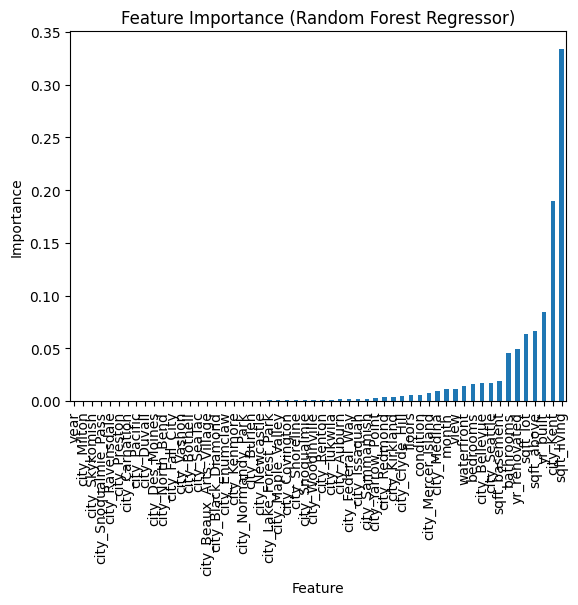

In [154]:
importance_df.plot(kind='bar')
plt.title('Feature Importance (Random Forest Regressor)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

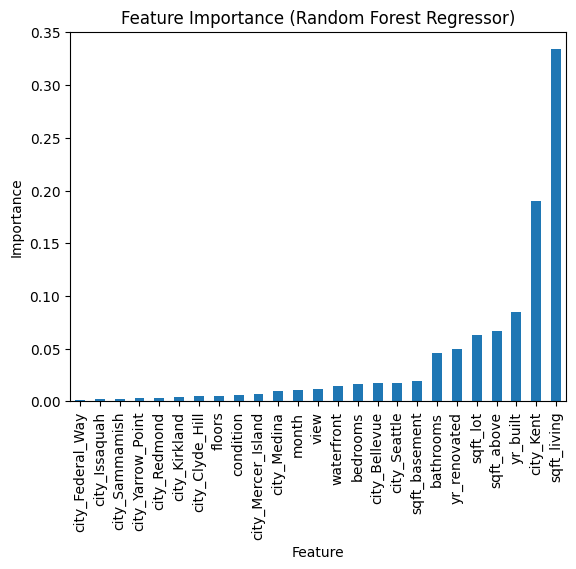

In [159]:
importance_df[importance_df > 1.647601e-03].plot(kind='bar')
plt.title('Feature Importance (Random Forest Regressor)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
